In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Data Preprocessing and Analysis

In [45]:
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

In [46]:
# For data preprocessing and analysis part
data = pd.read_csv('../input/price-volume-data-for-all-us-stocks-etfs/Stocks/abe.us.txt')
# Any CSV or TXT file can be added here....
data.dropna(inplace=True)
data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,6.4987,6.6009,6.4668,6.5753,55766,0
1,2005-02-28,6.6072,6.7669,6.5944,6.6263,49343,0
2,2005-03-01,6.6391,6.6773,6.6072,6.6072,31643,0
3,2005-03-02,6.5753,6.6072,6.5434,6.5816,27101,0
4,2005-03-03,6.5753,6.6135,6.5562,6.5944,17387,0


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3190 entries, 0 to 3189
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     3190 non-null   object 
 1   Open     3190 non-null   float64
 2   High     3190 non-null   float64
 3   Low      3190 non-null   float64
 4   Close    3190 non-null   float64
 5   Volume   3190 non-null   int64  
 6   OpenInt  3190 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 199.4+ KB


In [48]:
data.describe()

,Open,High,Low,Close,Volume,OpenInt
count,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.0
mean,11.599416,11.712848,11.484610,11.605599,28444.870846,0.0
std,2.350376,2.365621,2.327065,2.341989,37525.175821,0.0
min,5.860300,5.905000,5.834700,5.841100,106.000000,0.0
25%,10.534000,10.655000,10.413750,10.554000,8147.750000,0.0
50%,11.981000,12.067000,11.899000,11.988500,17741.500000,0.0
75%,13.271000,13.386750,13.189000,13.295750,36167.250000,0.0
max,18.130000,19.151000,17.842000,17.925000,634041.000000,0.0


In [49]:
data.isnull().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

In [50]:
data.reset_index(drop=True, inplace=True)
data.fillna(data.mean(), inplace=True)
data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,6.4987,6.6009,6.4668,6.5753,55766,0
1,2005-02-28,6.6072,6.7669,6.5944,6.6263,49343,0
2,2005-03-01,6.6391,6.6773,6.6072,6.6072,31643,0
3,2005-03-02,6.5753,6.6072,6.5434,6.5816,27101,0
4,2005-03-03,6.5753,6.6135,6.5562,6.5944,17387,0


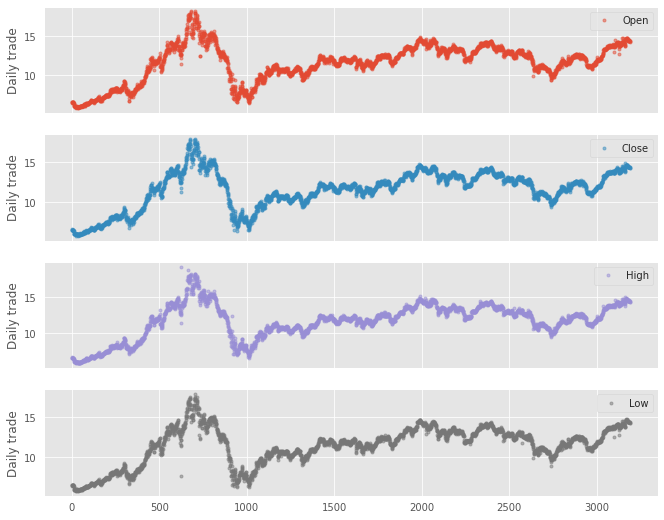

In [53]:
cols_plot = ['Open', 'Close', 'High','Low']
axes = df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

         Open     High      Low    Close  Volume  OpenInt
0      6.4987   6.6009   6.4668   6.5753   55766        0
1      6.6072   6.7669   6.5944   6.6263   49343        0
2      6.6391   6.6773   6.6072   6.6072   31643        0
3      6.5753   6.6072   6.5434   6.5816   27101        0
4      6.5753   6.6135   6.5562   6.5944   17387        0
...       ...      ...      ...      ...     ...      ...
3185  14.3998  14.4802  14.3900  14.4400   62423        0
3186  14.4400  14.4400  14.4000  14.4000    6722        0
3187  14.3400  14.4352  14.3400  14.3781    6304        0
3188  14.3300  14.3737  14.2800  14.3200   18761        0
3189  14.2500  14.3000  14.2400  14.3000   10658        0

[3190 rows x 6 columns]


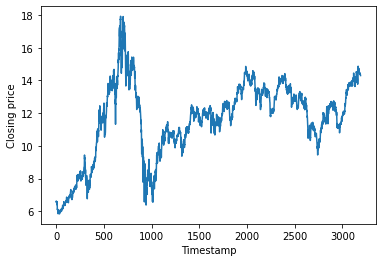

In [35]:
plt.plot(data['Close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")

df = data.drop('Date', axis=1)
print(df)

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = []
Y = []
window_size=100
for i in range(1 , len(df) - window_size -1 , 1):
    first = df.iloc[i,3]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df.iloc[i + j, 3] - first) / first)
    # for j in range(week):
    temp2.append((df.iloc[i + window_size, 3] - first) / first)
    # X.append(np.array(stock.iloc[i:i+window_size,4]).reshape(50,1))
    # Y.append(np.array(stock.iloc[i+window_size,4]).reshape(1,1))
    # print(stock2.iloc[i:i+window_size,4])
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

2470
618


## Training part

In [63]:
# For creating model and training
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy

model = tf.keras.Sequential()

# Creating the Neural Network model here...
model.add(TimeDistributed(Conv1D(64, kernel_size=1, activation='relu', input_shape=(None, 50, 1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=1, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=1, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
model.add(Dense(5, kernel_regularizer=L1(0.01)))
model.add(Bidirectional(LSTM(200, return_sequences=True)))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(200, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=[Accuracy()])

history = model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=25,batch_size=64, verbose=1, shuffle =True)

Epoch 1/25
39/39 [==============================] - 8s 42ms/step - loss: 1.3811 - accuracy: 0.0000e+00 - val_loss: 0.5432 - val_accuracy: 0.0000e+00
Epoch 2/25
39/39 [==============================] - 0s 11ms/step - loss: 0.3755 - accuracy: 0.0000e+00 - val_loss: 0.0500 - val_accuracy: 0.0000e+00
Epoch 3/25
39/39 [==============================] - 0s 11ms/step - loss: 0.0319 - accuracy: 0.0000e+00 - val_loss: 0.0126 - val_accuracy: 0.0000e+00
Epoch 4/25
39/39 [==============================] - 0s 11ms/step - loss: 0.0111 - accuracy: 0.0000e+00 - val_loss: 0.0087 - val_accuracy: 0.0000e+00
Epoch 5/25
39/39 [==============================] - 0s 11ms/step - loss: 0.0083 - accuracy: 0.0000e+00 - val_loss: 0.0086 - val_accuracy: 0.0000e+00
Epoch 6/25
39/39 [==============================] - 0s 11ms/step - loss: 0.0082 - accuracy: 0.0000e+00 - val_loss: 0.0078 - val_accuracy: 0.0000e+00
Epoch 7/25
39/39 [==============================] - 0s 11ms/step - loss: 0.0077 - accuracy: 0.0000e+00 - v

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_28 (TimeDis (None, 1, 100, 64)        128       
_________________________________________________________________
time_distributed_29 (TimeDis (None, 1, 50, 64)         0         
_________________________________________________________________
time_distributed_30 (TimeDis (None, 1, 50, 128)        8320      
_________________________________________________________________
time_distributed_31 (TimeDis (None, 1, 25, 128)        0         
_________________________________________________________________
time_distributed_32 (TimeDis (None, 1, 25, 64)         8256      
_________________________________________________________________
time_distributed_33 (TimeDis (None, 1, 12, 64)         0         
_________________________________________________________________
time_distributed_34 (TimeDis (None, 1, 768)           

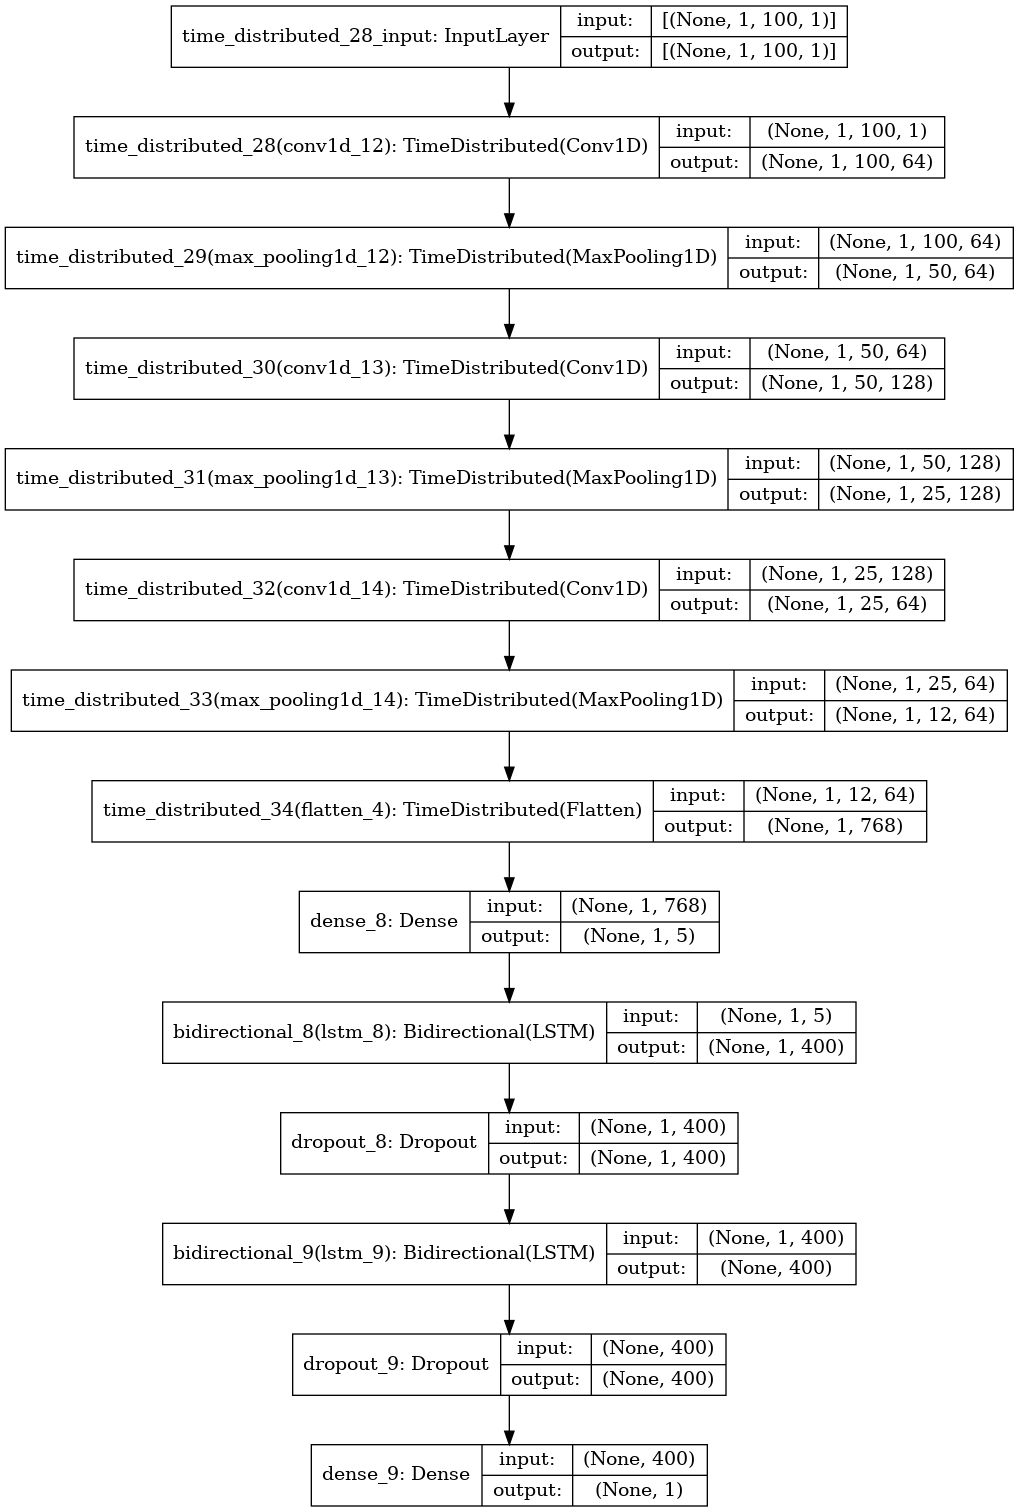

In [56]:
# After the model has been constructed, we need to train
from tensorflow.keras.utils import plot_model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

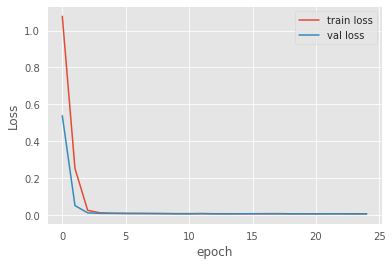

In [57]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [58]:
model.evaluate(test_X, test_Y)

20/20 [==============================] - 0s 4ms/step - loss: 0.0063 - accuracy: 0.0000e+00


[0.006305329035967588, 0.0]

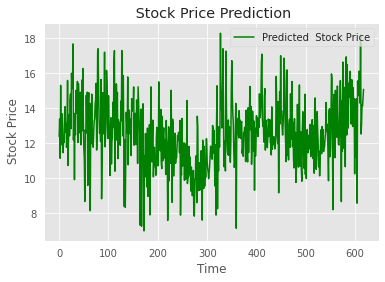

In [59]:
predicted  = model.predict(test_X)
test_label = (test_Y)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp =data.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

## Testing part

In [42]:
# First we need to save a model
model.save("model.h5")

In [43]:
# Load model
new_model = tf.keras.models.load_model("./model.h5")

In [44]:
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_21 (TimeDis (None, 1, 100, 64)        128       
_________________________________________________________________
time_distributed_22 (TimeDis (None, 1, 50, 64)         0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 1, 50, 128)        8320      
_________________________________________________________________
time_distributed_24 (TimeDis (None, 1, 25, 128)        0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, 1, 25, 64)         8256      
_________________________________________________________________
time_distributed_26 (TimeDis (None, 1, 12, 64)         0         
_________________________________________________________________
time_distributed_27 (TimeDis (None, 1, 768)           